**LIBRARIES**

In [ ]:
!pip install --upgrade pip
!pip install matplotlib
!pip install tensorflow
!pip install keras
!pip install visualkeras
!pip install tf-keras-vis

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import shutil
import random
import itertools
import pprint
import json
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
current_directory = os.getcwd()
base_dir = os.path.dirname(os.path.abspath('__file__'))
os.chdir(base_dir)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
import visualkeras
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
print(tf.__version__)

2.15.0


# **DATA SOURCES**

In [5]:
base_folder = '.'
# adjust the variable base_folder to whatever directory will contain esca_dataset and esca_dataset_swapped_bg

data_folders = {
    '.': base_folder,
    'esca_dataset': {
        '.': os.path.join(base_folder, 'esca_dataset'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset', 'train'),
            'esca': os.path.join(base_folder, 'esca_dataset', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset', 'validation'),
            'esca':    os.path.join(base_folder, 'esca_dataset', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'validation', 'healthy')
        }
    },
    'esca_dataset_swapped_bg': {
        '.': os.path.join(base_folder, 'esca_dataset_swapped_bg'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train'),
            'esca':    os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation'),
            'esca': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation', 'healthy')
        }
    },
    'esca_dataset_mixed': {
        '.': os.path.join(base_folder, 'esca_dataset_mixed'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'train'),
            'esca':    os.path.join(base_folder, 'esca_dataset_mixed', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset_mixed', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'validation'),
            'esca': os.path.join(base_folder, 'esca_dataset_mixed', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'validation', 'healthy')
        }
    }
}

# Serializing json
json_object = json.dumps(data_folders, indent = 4)
print(json_object)

{
    ".": ".",
    "esca_dataset": {
        ".": "./esca_dataset",
        "train": {
            ".": "./esca_dataset/train",
            "esca": "./esca_dataset/train/esca",
            "healthy": "./esca_dataset/train/healthy"
        },
        "test": {
            ".": "./esca_dataset/test",
            "esca": "./esca_dataset/test/esca",
            "healthy": "./esca_dataset/test/healthy"
        },
        "validation": {
            ".": "./esca_dataset/validation",
            "esca": "./esca_dataset/validation/esca",
            "healthy": "./esca_dataset/validation/healthy"
        }
    },
    "esca_dataset_swapped_bg": {
        ".": "./esca_dataset_swapped_bg",
        "train": {
            ".": "./esca_dataset_swapped_bg/train",
            "esca": "./esca_dataset_swapped_bg/train/esca",
            "healthy": "./esca_dataset_swapped_bg/train/healthy"
        },
        "test": {
            ".": "./esca_dataset_swapped_bg/test",
            "esca": "./esca_dataset_

In [5]:
!python --version

Python 3.10.8


**FUNCTIONS**

In [6]:
def count_images(folder_path):
    total_files = 0
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                if os.path.isfile(file_path) and (file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.JPG') or file_path.endswith('.JPEG')):
                    total_files += 1
    return total_files

In [7]:
data_folders_info = {
    'esca_dataset': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['validation']['healthy'])
        }
    },
    'esca_dataset_swapped_bg': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['validation']['healthy'])
        }
    },
    'esca_dataset_mixed': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['validation']['healthy'])
        }
    }
}

# Serializing json
json_object = json.dumps(data_folders_info, indent = 4)
print(json_object)

{
    "esca_dataset": {
        "train": {
            "esca": 8680,
            "healthy": 8638
        },
        "test": {
            "esca": 134,
            "healthy": 133
        },
        "validation": {
            "esca": 134,
            "healthy": 132
        }
    },
    "esca_dataset_swapped_bg": {
        "train": {
            "esca": 8638,
            "healthy": 8694
        },
        "test": {
            "esca": 133,
            "healthy": 134
        },
        "validation": {
            "esca": 132,
            "healthy": 133
        }
    },
    "esca_dataset_mixed": {
        "train": {
            "esca": 17318,
            "healthy": 17332
        },
        "test": {
            "esca": 267,
            "healthy": 267
        },
        "validation": {
            "esca": 266,
            "healthy": 265
        }
    }
}


**EXECUTE THE FOLLOWING CELL TO LOAD BOTH THE ORIGINAL AND THE RETRAINED MODEL**

In [8]:
MODELS_PATH = '.'
models_list = [
    {
        'model': load_model(os.path.join(MODELS_PATH, 'CNN_Esca_model.keras')),
        'description': 'Original model'
    },
    {
        'model': load_model(os.path.join(MODELS_PATH, 'CNN_Esca_model_retrained.keras')),
        'description': 'Retrained model'
    }
]

**LOAD TEST SETS TO PERFORM MODEL EVALUATION**

In [9]:
img_width, img_height = 128, 128
########################################################
dataset_names = ['esca_dataset', 'esca_dataset_swapped_bg', 'esca_dataset_mixed']
########################################################
# looping through pairs of models and evaluation data
for model_record, dataset_name in itertools.product(models_list, dataset_names):
    evaluation_dataset = image_dataset_from_directory(data_folders[dataset_name]['test']['.'],
                                            labels='inferred',
                                            shuffle=False,
                                            color_mode='rgb',
                                            batch_size=1,
                                            image_size=(img_width, img_height),
                                            label_mode='categorical')
    evaluation_dataset = evaluation_dataset.map(lambda images, labels: ((images/255.0), labels))
    print('-----------------------------------------------')
    print(f"{model_record['description']} on {dataset_name}/test")
    start = time.time()
    evaluate = model_record['model'].evaluate(evaluation_dataset)
    elapsed_time = time.time() - start
    print('Test loss:',     evaluate[0])
    print('Test accuracy:', evaluate[1])
    print('Average image inference time %.2f msec\n'%(1000*(elapsed_time/len(evaluation_dataset))))

Found 267 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset/test
267/267 [==============================] - 4s 14ms/step - loss: 0.0520 - accuracy: 0.9888
Test loss: 0.05201272293925285
Test accuracy: 0.9887640476226807
Average image inference time 15.02 msec
Found 267 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset_swapped_bg/test
267/267 [==============================] - 3s 9ms/step - loss: 1.9354 - accuracy: 0.8240
Test loss: 1.9353731870651245
Test accuracy: 0.8239700198173523
Average image inference time 9.66 msec
Found 534 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset_mixed/test
534/534 [==============================] - 4s 8ms/step - loss: 0.9937 - accuracy: 0.9064
Test loss: 0.993692934513092
Test accuracy: 0.9063670635223389
Average image inference time 8.27 msec
Found 267 files belonging to 2 cl

In [10]:
# **************          matrix_confusion         ***************

# Mette a confronto due liste:  una contenente le labels originali delle immagini di test,
#                               l'altra contenente le labels predette dalla CNN.

# Parameters:
#                - original :           lista contenente le labels originali delle immagini
#                - model:               lista contenente le labels predette
#                - n_class :            numero di classi
#                - nb_test_samples :    numero di immagini di test

# Return:
#               - confusion_matrix :    matrice di confusione.

def matrix_confusion(original, model, n_class, nb_test_samples):

    # creo una matrice di zeri, di dimensioni corrispondenti al numero di classi
    confusion_matrix = np.zeros((n_class,n_class))


    # confronto le due liste contenenti le label vere e quelle predette.
    l = len(original)
    k=0
    while k<l:
        confusion_matrix[original[k]][model[k]] += 1
        k+=1

    print('matrice di confusione \n', confusion_matrix)
    print('\n')

    # calcolo l'accuratezza delle predizioni

    correct_predictions = sum(confusion_matrix[i][i] for i in range(n_class))

    total_prediction = nb_test_samples

    accuracy = correct_predictions/total_prediction

    print('ACCURACY... : ' , round(accuracy*100, 2), '%')
    print('\n')
    return confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


**EVALUATE ALL TWO MODELS ON ALL THREE TEST SETS**

Found 267 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset/test
267/267 [==============================] - 1s 3ms/step
predictions shape:  (267, 2)
predictions :  [9.9999976e-01 2.5680032e-07]
matrice di confusione 
 [[133.   1.]
 [  2. 131.]]


ACCURACY... :  98.88 %


Average image inference time 3.47 msec

Confusion matrix, without normalization
[[133   1]
 [  2 131]]


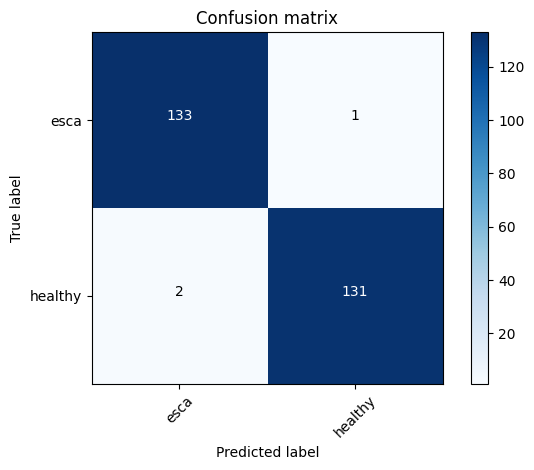

Found 267 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset_swapped_bg/test
267/267 [==============================] - 1s 3ms/step
predictions shape:  (267, 2)
predictions :  [1.00e+00 4.17e-12]
matrice di confusione 
 [[119.  14.]
 [ 33. 101.]]


ACCURACY... :  82.4 %


Average image inference time 3.11 msec

Confusion matrix, without normalization
[[119  14]
 [ 33 101]]


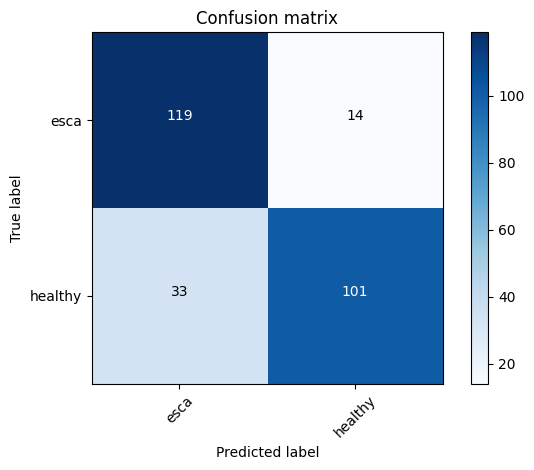

Found 534 files belonging to 2 classes.
-----------------------------------------------
Original model on esca_dataset_mixed/test
534/534 [==============================] - 2s 3ms/step
predictions shape:  (534, 2)
predictions :  [1.00e+00 2.57e-07]
matrice di confusione 
 [[252.  15.]
 [ 35. 232.]]


ACCURACY... :  90.64 %


Average image inference time 3.27 msec

Confusion matrix, without normalization
[[252  15]
 [ 35 232]]


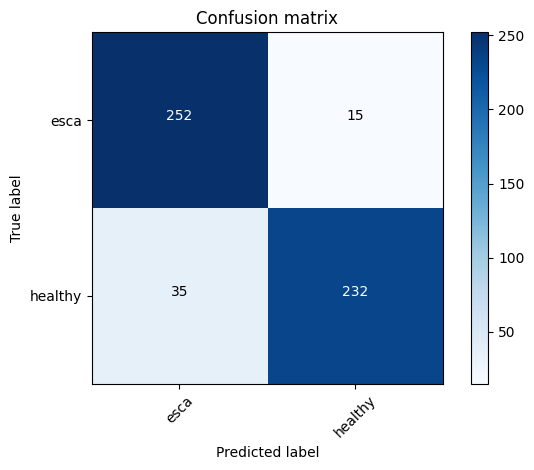

Found 267 files belonging to 2 classes.
-----------------------------------------------
Retrained model on esca_dataset/test
267/267 [==============================] - 1s 3ms/step
predictions shape:  (267, 2)
predictions :  [1.00e+00 3.31e-17]
matrice di confusione 
 [[133.   1.]
 [  0. 133.]]


ACCURACY... :  99.63 %


Average image inference time 3.52 msec

Confusion matrix, without normalization
[[133   1]
 [  0 133]]


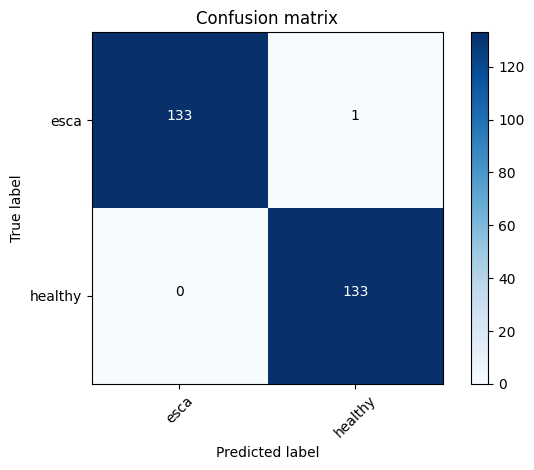

Found 267 files belonging to 2 classes.
-----------------------------------------------
Retrained model on esca_dataset_swapped_bg/test
267/267 [==============================] - 1s 3ms/step
predictions shape:  (267, 2)
predictions :  [1.00e+00 5.21e-15]
matrice di confusione 
 [[132.   1.]
 [  3. 131.]]


ACCURACY... :  98.5 %


Average image inference time 3.30 msec

Confusion matrix, without normalization
[[132   1]
 [  3 131]]


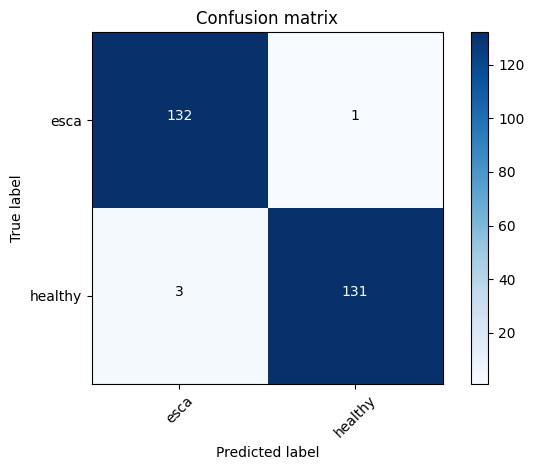

Found 534 files belonging to 2 classes.
-----------------------------------------------
Retrained model on esca_dataset_mixed/test
534/534 [==============================] - 2s 4ms/step
predictions shape:  (534, 2)
predictions :  [1.00e+00 3.31e-17]
matrice di confusione 
 [[265.   2.]
 [  3. 264.]]


ACCURACY... :  99.06 %


Average image inference time 3.78 msec

Confusion matrix, without normalization
[[265   2]
 [  3 264]]


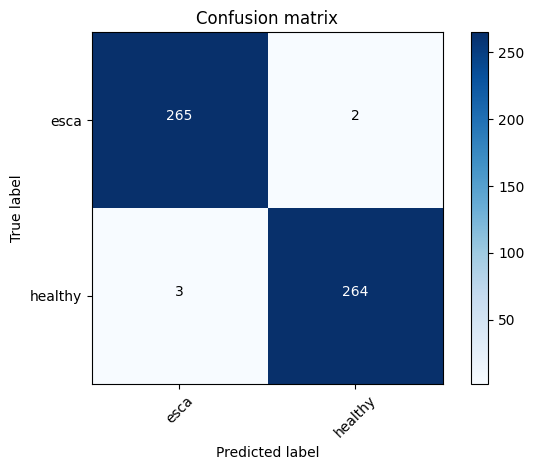

In [11]:
########################################################
dataset_names = ['esca_dataset', 'esca_dataset_swapped_bg', 'esca_dataset_mixed']
########################################################
n_class = 2
for model_record, dataset_name in itertools.product(models_list, dataset_names):
    test_dataset = image_dataset_from_directory(data_folders[dataset_name]['test']['.'],
        labels='inferred',
        shuffle=False,
        color_mode='rgb',
        batch_size=1,
        image_size=(img_width, img_height),
        label_mode='int')
    print('-----------------------------------------------')
    print(f"{model_record['description']} on {dataset_name}/test")
    test_images = test_dataset.map(lambda images, labels: (images/255.0))
    test_labels = test_dataset.map(lambda images, labels: labels)
    test_labels = test_labels.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
    test_labels_orig = list(test_labels.as_numpy_iterator())
    start = time.time()
    predictions = model_record['model'].predict(test_images)
    end = time.time()
    elapsed_time = end - start
    print("predictions shape: ", predictions.shape)
    print("predictions : ", predictions[0])
    # result of predictions
    pred_labels = [np.argmax(x) for x in predictions]
    # matrix confusion  ----------------------------------------
    matrix = matrix_confusion(test_labels_orig, pred_labels, n_class, len(test_dataset))
    print('Average image inference time %.2f msec\n'%(1000*(elapsed_time/len(test_dataset))))    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_labels_orig, pred_labels)
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['esca', 'healthy'],
                          title='Confusion matrix')
    
    plt.show()